![Python Programming for Scientists in a hurry](./fig/Title_Python.png)

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 9. Parallel Computing</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## List of Notebooks

Python is a great general-purpose programming language on its own.
Python is a general purpose programming language. It is interpreted and dynamically typed and is very suited for interactive work and quick prototyping while being powerful enough to write large applications in.
The lesson is particularly oriented to Scientific Computing. 
Other episodes in the series include:

  * Language Syntax
  * Standard Library
  * Scientific Packages
  * NumPy
  * Matplotlib
  * SciPy 
  * Pandas
  * Cython
  * **Parallel Computing \[This notebook\]**

After completing all the series in this lesson you will realize that python has become a powerful environment for scientific computing at several levels, from interactive computing to scripting to big project developments.

## Setup

In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2024-07-25T17:35:54.493703-04:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.14.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
import time
start = time.time()
chapter_number = 9
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%watermark -iv

matplotlib: 3.8.2
numpy     : 1.26.2



# Parallel Computing

Everything we have discussed now only refers to calculations that use a single processor, but Python already offers a series of tools and implementations for parallel computing. In this notebook, we will discuss some of the possible uses and existing libraries on Parallel python. Up to now, we have made choices on the libraries we have been using, but we would like to stress that this is a very important step in the case of high-performance computing. As this is going to be an important factor, let us recall a function that we will use a lot %timeit. This is just a method to measure the time used for the computation.

As you can imagine, not all algorithms are parallelizable and that is something we need to keep in mind. Also, Python is not the programming language for parallelization but, as you have already covered a lot, I think, it is a good idea that we used to build the basics of parallel computing.

Another issue is how to improve Python performance. Python was not designed specifically for numerical applications but we can indeed use different packages created for this purpose. This is what is going to be discussed here. We will discuss, where it is going to be a good idea to communicate with an external package (probably created by a compiled language) or when the overhead could be so big that using python would be better.

# Intrinsic Parallelization (Numpy and Scipy)

As discussed, the core part of Numpy is to deal with NumPy arrays. This library has a lot of functionality, where many of the functions come from intrinsic implementations from C or Fortran. Usually, the library relies on Lapack or BLAS to perform low-level computations (if the libraries already exist in your library, you need to configure and compile Numpy in your system. To check which configuration you are using run the following commands

In [6]:
import numpy, scipy
numpy.__config__.show()
scipy.__config__.show()

Build Dependencies:
  blas:
    detection method: system
    found: true
    include directory: unknown
    lib directory: unknown
    name: openblas
    openblas configuration: unknown
    pc file directory: unknown
    version: 0.3.25
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4544045072
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: /usr/bin/clang
    linker: ld64
    name: clang
    version: 11.0.3
  c++:
    commands: /usr/bin/clang++
    linker: ld64
    name: clang
    version: 11.0.3
  cython:
    commands: /opt/local/bin/cython-3.11
    linker: cython
    name: cython
    version: 0.29.36
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x86_64
    system: darwin
  host:
    cpu: x86_64
    endian: little
    family: x86_64
    system: darwin
Python Information:
  path: /opt/local/Library/Framework

If they are not linked to CLAS of LAPACK, you will need to reconfigure your Numpy. For such, you can look on the web on how to do that.
Now, the operations in Numpy are vectorized, which means that if we add two vectors and they do not have the same dimension, it will raise an error. For example

In [7]:
import numpy as np

```python
a=np.ones(10); b=np.ones(8)
a+b
```
    ---------------------------------------------------------------------------
    ValueError                                Traceback (most recent call last)
    Input In [6], in <cell line: 2>()
          1 a=np.ones(10); b=np.ones(8)
    ----> 2 a+b

    ValueError: operands could not be broadcast together with shapes (10,) (8,) 


In [8]:
a=np.ones(10); b=np.ones(10)
a+b

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

The reason why is it better to use addition or other functions of NumPy arrays, is because these operations are implemented already in C and NumPy is just the interface.

Now, a note on the side, do not confuse element-wise multiplication (A*B) with matrix multiplication (dot(A,B)). For example

In [9]:
a=np.ones((4,4))
b=np.random.rand(4,4)

In [10]:
a*b

array([[0.50618277, 0.88227263, 0.47370527, 0.26355074],
       [0.5325218 , 0.3468359 , 0.06801318, 0.26300101],
       [0.967358  , 0.85580381, 0.49835072, 0.81961897],
       [0.15663472, 0.28152378, 0.54711352, 0.81059243]])

In [11]:
np.dot(a,b)

array([[2.16269729, 2.36643612, 1.58718268, 2.15676315],
       [2.16269729, 2.36643612, 1.58718268, 2.15676315],
       [2.16269729, 2.36643612, 1.58718268, 2.15676315],
       [2.16269729, 2.36643612, 1.58718268, 2.15676315]])

## Speeding Python

Now, as we discussed, there are many other properties in NumPy that are useful in parallel computing. In particular, when it is used with other packages, as is the case of SciPy. As discussed in the SciPy chapter, this package contains many different algorithms to perform interpolation, Fourier analysis, linear algebra, ordinary differential equations, etc. A great majority of the algorithms are written in C or Fortran and interfaced with Python in this library. 
We have discussed several examples in the SciPy chapter, but let us here recap and used them for the solution of a set of ordinary differential equations. Here, we will use the wrapper odeint, which is a Scipy function on top of the *lsoda* Fortran function. If we time this routine and compare it with the compiled version, we will see that Python is slow. This is mainly because Python has to communicate with the Fortran version, pass the data, wait for the one step and do the interpretation of the result.

In [12]:
import scipy.integrate

# Parameters from Google

sigma = 10
rho = 28
beta = 8.0/3

def lorenz(xyz, t):
    x,y,z = xyz
    xdot = sigma*(y-x)
    ydot = x*(rho-z) - y
    zdot = x*y - beta*z
    return [xdot, ydot, zdot]

def integrate_lorenz(ic=[1.,1.,1.]):
    traj = scipy.integrate.odeint(lorenz, ic, np.arange(0., 1000., 0.05))
    return traj

In [13]:
d=integrate_lorenz()
print(d.shape)

(20000, 3)


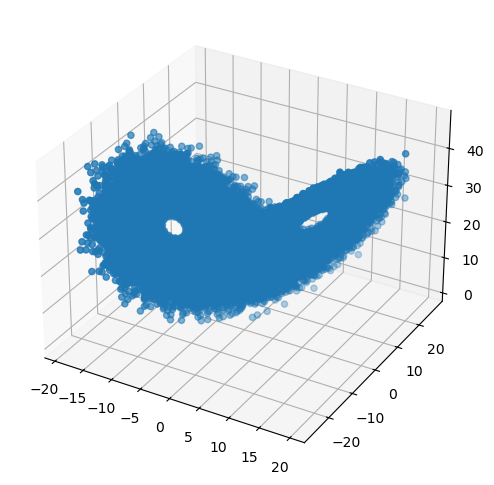

In [14]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
ax.scatter(d[:,0], d[:,1], d[:,2], label='parametric curve')

plt.show()


Now, we have already discussed that using these libraries can be slow. We can improve the performance by using existing libraries that create the C code or the machine language that makes this faster. We have discussed the case of Cython but there is another package that is easy to use, the so-called JIT (just in time), which creates C compiled version on the fly. Let's see how to use it

In [15]:
from numba import jit

@jit
def numba_lorenz(xyz,t):
    x,y,z = xyz
    xdot = sigma*(y-x)
    ydot = x*(rho-z) - y
    zdot = x*y - beta*z
    return [xdot, ydot, zdot]

def integrate_numba_lorenz(ic=[1.,1.,1.]):
    res = scipy.integrate.odeint(numba_lorenz, ic, np.arange(0., 500., 0.05))
    return res

ModuleNotFoundError: No module named 'numba'

In [ ]:
%timeit integrate_lorenz()
%timeit integrate_numba_lorenz()

Ok, now we can see that by introducing simple flags we can get performance close to C or Fortran. That is nice and for that, you can use some other libraries:


+ CFFI and ctypes provide "foreign function interfaces", or lightweight APIs, for calling C libraries from within Python. This library allows you to use existing libraries in your computers as those dylib or so in your distribution .
+ Boost.python helps write C++ libraries that Python can import and use easily.
+ SWIG reads C and C++ header files and generates a library that Python can load.
+ F2PY reads Fortran code and generates a library that Python can load.
+ PyCUDA and PyOpenCL provide access within Python to GPUs.

You can also write C code by hand, that can be called from Python code.

Now that we are getting more into the optimization of the Python implementation, it is important that we review how we manage different data collections. We have discussed that Python has four different data containers:

+ lists: mutable sequence and a collection of objects in definite order 
+ tuple: unmutable sequence and a collection of objects in definite order
+ dict: a mapping and unordered associated keys
+ set: unordered collection of unique elements

The performance of different actions on the different containers is sometimes different and that is why we need to select a good container depending on the application. To show why this is true, let us take the following example (just finding the intersection between two big lists):

In [ ]:
a = set(range(0,10000))
b = set(range(0,10000))
%timeit c = a & b

In [ ]:
a = list(range(0,10000))
b = list(range(0,10000))
%timeit c = [e1 for e1 in a for e2 in b if e1==e2]

Keep this in mind for your application. Always think about the container and if there are tools that allow you to search efficiently over the containers (for example using itertools). Now let's see some simple techniques we can use to make our code faster or better.

## Lazyness

The idea here is to create objects only when they are needed

+ Generators: these are functions that create an output but still remember its internal state and therefore can create a succession of actions. A simple example is a *for* loop which can create a sequence of data or actions with a predefined stop. 

+ range: a function that creates a sequence of integer numbers. 

+ zip:  this is a function that "zip" two or more iterables together. 

+ open: we can always open a file but then read the whole thing at once: for example

with open("inputfile","r") as f:
     data=f.readlines()
     
Now data contains everything from the file, one line at a time.


In [ ]:
a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica", "Vicky")
c = list(range(0,10))
d = list(range(30,40))

x = zip(a, b)
print(x)
print(list(x))
x = zip(c,d)
for y in x:
    print(list(y))
    
# Now we can use itertools to fill the missing data in case you are interested in that

from itertools import zip_longest

c = range(6,10)
d = range(5)
zipped = zip_longest(a, b, d, fillvalue='?')

print(list(zipped))

# Another use of zip 


for l, n in zip(c,d):
    print(f'Number in c: {l}')
    print(f'Number in d: {n}')


## Memory Management

Though it is quite important we optimize our program, one issue that the user needs to take always into account is the memory management, as it can also impact the code performance. In the case of Python, memory is freed only after the program does not have any other reference to that memory. In C or C++, you always have to allocate or deallocate dynamic memory, while in Python it is not the case. This seems like very reasonable memory management but the problem is that the interpreter does not return the memory to the operating system, instead, it remains allocated, just in case, the user needs it. Therefore, if the system you are running is capped in memory, you will run into trouble. 

### Memory Profiler

To measure the memory use in Python, there are several tricks we can use, for example, we can do it for particular objects

In [ ]:
import sys
import numpy as np
import random
a=np.random.rand(200)
sys.getsizeof(a)
#create a list of random integers
res = [random.randrange(1, 50, 1) for i in range(7)] 
print(res)
sys.getsizeof(res)

If you want to get information about a script you have written, you can use the command

python -m memory_profiler myscript.py

Or you can also **use mprof**, which plots the memory used in an application. The use is very simple, download the cell below into a script and call it time.py. Then the use is

mprof run time.py

This command creates a *.dat* file, which is a raw text file that contains the memory use. This can be easily plotted by using 

mprof plot

One detail concerning the script below. We use the "@profile" to define the regions where we want to measure the memory use and also we have included a time delay of one second before returning from the subroutine, as we want to allow the system to gather the memory information.



The most important message for memory management is that if we know the size of a vector or a matrix, we need to define it in advance. Only use "append" if you do not know the size of your structure. In the case of NumPy, you can create preallocated arrays by using `np.zeros()` or `np.empty()`. Also, keep in mind  that if we "change" the dimensions or increase the size of a complex array, everything has to be shifted and this will have a computational and memory penalty.

## Parallel Computation

Up to now, we have been using that our code runs serially, but there are many cases where we can see an improvement over performance if we use parallelization. 

Here we understand parallelization as a **task** we can perform simultaneously in different processors at the same time, similar to when you eat, read and write at the same time. Now, the main task we plan to solve can be done on the same computer but then we can have memory issues (memory overhead), or we can have time overhead (some of the sub-tasks take longer than others and we have to wait to continue) or bandwidth overhead, which happens when we have to transfer big chunks of data to the hard drive. We will discuss some solutions later on.

Now, before we dive in, it is important that you keep in mind what type of problems we can parallelize. Those that can be split in **sub-tasks** such that the sub-tasks do communicate just a bit with the neighbor ones or no communication at all. If they do not communicate, the problem is called trivially parallelizable. For this last case, a simple case is to add two big vectors. We can divide the vectors into sections and every section is completely independent of the others. 

Of course, in the general case, we will require to know several computational schemes, the ins, and outs of your application, etc. We need to use existing tools that support this idea. For that, we rely on existing standard libraries that will do the job for us. Here we will discuss only a few but the most used one is an interface on top of the MPI (message-passing library) such as mpi4py, multiprocessing, or Dask which has been integrated with many other scientific libraries.

Now, depending on your available computer, you can face two different memory situations.

+ Shared memory. Here, the sub-tasks communicate with each other through the same memory space (the computer has to have enough memory to allow all sub-tasks to have the required memory). Though we can run into trouble by accessing some data from memory as this can modify it at the same time that is read by other sub-tasks, we solve the problem by using synchronization techniques. In this case, a very well-known method is to use threads, which exist in many different languages but it is not possible in Python. First of all, we should notice that the CPython interpreter is single-threaded by design and threads can only be run in a single node. 

+ Distributed memory. Here each sub-task has its own assigned memory space and we only need to worry about the communication between the different sub-tasks. 



Let's start with the multiprocessing module, a thread-like interface to multiple Python processes (note: process creation is more expensive than thread creation, though it is better than serial, a full thread parallelization would be faster than processing). Interestingly enough, this method leverage multiple processors on a given machine.

One is a master-worker paradigm, using the map() function. This function parallelizes the execution of a function across multiple input values. First, you define a Pool of workers, then you execute a function collectively on the Pool. 

In [ ]:
from multiprocessing import Pool
import sys
sys.path.insert(0, './scripts')

from worker import funcx2

p = Pool(4)                 # starts 4 worker processes
print(p.map(funcx2, range(10)))  # prints "[0, 1, 4,..., 81]"

The maximum number of processes you can run at a time is limited by the number of processors in your computer. 

We have used the map function within the Pool class, which gives a synchronous execution. Here we will discuss this type of execution and we encourage the reader to search for asynchronous execution. For this last case, processes can start without waiting that the others to be done, which can be of interest if data does not need to pass from different subtasks. 

For now, Let us discuss one example in detail and compare each case.

In [ ]:
#generate random numbers in a big matrix
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:10]

Now let us find how many numbers in this matrix are within a given range

In [ ]:
def counting_withinrange(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(counting_withinrange(row, minimum=4, maximum=8))

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

Now we use parallelization, this will be done by applying the function over a different set of data in a parallel environment, meaning that they will run over different processors. We will use the pool class. This class has three different methods:  apply(), map() and starmap().

In the case of application and map, they take the function to be parallelized as the main argument. But apply() takes an args argument that accepts the parameters passed to the ‘function-to-be-parallelized’ as an argument, whereas, a map can take only one iterable as an argument (map is easier for iterable operations). The starmap() is similar to map() but allows to have different iterable parameters. 

In [ ]:
#Let us start with apply()
import multiprocessing as mp

from worker import counting_withinrange

# request how many processors I have available
pool = mp.Pool(mp.cpu_count())

# `pool.apply` the `counting_withinrange()`
results = [pool.apply(counting_withinrange, args=(row, 4, 8)) for row in data]

# close (IMPORTANT, otherwise you will have leakage!!)
pool.close()    

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
#Using map()
import multiprocessing as mp

# We change the function, such we have only ONE parameter.
def counting_withinrange(row, minimum=4, maximum=8):
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

from worker import counting_withinrange1

pool = mp.Pool(mp.cpu_count())

results = pool.map(counting_withinrange1, [row for row in data])

pool.close()

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Using starmap()
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

results = pool.starmap(counting_withinrange1, [(row, 4, 8) for row in data])

pool.close()

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

Up to now, we have discussed the parallelization using multiprocessing. Now, let us use a different library, just to compare how it is used. For this, we have to rely on a different approach. We will use the library mpi4py but this library is easier to be used outside of Jupyter notebooks. For that, I have created a file: examplempi.py in the same directory where the notebooks are stored. This example sent some data from the array numData from processor 0 to processor 1. 

The file contains the following example, though here we have commented all lines

In [ ]:
##from mpi4py import MPI
#import numpy as np

#comm = MPI.COMM_WORLD
#rank = comm.Get_rank()

#if rank == 0:
#    # in real code, this section might
#    # read in data parameters from a file
#    size data that will be sent to another processor
#    numData = 10  
#    comm.send(numData, dest=1)

#    data = np.linspace(0.0,3.14,numData)  
#    comm.Send(data, dest=1)

#elif rank == 1:

#    numData = comm.recv(source=0)
#    print('Number of data to receive: ',numData)

#    data = np.empty(numData, dtype='d')  # allocate space to receive the array
#    comm.Recv(data, source=0)

#    print('data received: ',data)

In [ ]:
#Then in the command line we will run
!mpirun -n 4 python  examplempi.py

A very good discussion on how to use mpi4py can be found at https://rabernat.github.io/research_computing/parallel-programming-with-mpi-for-python.html

# Acknowledgments and References

This Notebook has been adapted by **Guillermo Avendaño** (WVU), **Jose Rogan** (Universidad de Chile) and **Aldo Humberto Romero** (WVU) from the [Tutorials for Stanford cs228 and cs231n](https://github.com/kuleshov/cs228-material). A large part of the info was also built from scratch. In turn, that material was adapted by [Volodymyr Kuleshov](http://web.stanford.edu/~kuleshov/) and [Isaac Caswell](https://symsys.stanford.edu/viewing/symsysaffiliate/21335) from the `CS231n` Python tutorial by Justin Johnson (http://cs231n.github.io/python-numpy-tutorial/). Another good resource, in particular, if you want to just look for an answer to specific questions is [planetpython.org](http:planetpython.org), in particular for data science.

Changes to the original tutorial include strict Python 3 formats and a split of the material to fit a series of lessons on Python Programming for WVU's faculty and graduate students.

The support of the National Science Foundation and the US Department of Energy under projects: DMREF-NSF 1434897, NSF OAC-1740111 and DOE DE-SC0016176 is recognized.

<div style="clear: both; display: table;">
<div style="border: none; float: left; width: 40%; padding: 10px">
<img src="fig/NSF.jpg" alt="National Science Foundation" style="width:50%" align="left">
    </div>
    <div style="border: none; float: right; width: 40%; padding: 10px">
<img src="fig/DOE.jpg" alt="National Science Foundation" style="width:50%" align="right">
</div>

# Back of the Book

In [ ]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [ ]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')